In [1]:
import pandas as pd
import pyodbc

In [4]:
AMAIA_2 = pd.read_csv('../../Data/AMAIA/AMAIA_LOAD_2020-11-17.csv')
AMAIA = pd.read_csv('../../Data/AMAIA/AMAIA_LOAD_20-11-25.csv')
ALL_DATA = pd.read_csv('../../Data/AMAIA/Unfiltered_Insurance_2020-11-17.csv')
PPD = pd.read_csv('../../Data/PPD/ppd_data_20201121.csv')

In [7]:
pe = pd.read_excel('../../Data/AMAIA/PRESENT_EMPLOYMENT_CODE_KEY.xlsx')
top = pd.read_excel('../../Data/AMAIA/TOP_CODE_KEY.xlsx')
spec = pd.read_csv('../../Data/PPD/speciality_id.csv')

In [21]:
def fix_me(me_list):
    '''Add leading zeroes to ME'''
    nums = []
    for num in me_list:
        num = str(num)
        num = num.replace('.0', '')
        if len(num) == 10:
            num = '0' + num
        elif len(num) == 9:
            num = '00' + num
        elif len(num) == 8:
            num = '000' + num
        nums.append(num)
    return nums

In [16]:
ppd = PPD[['ME', 'STATE', 'MD_DO_CODE', 
       'TOP_CD',
       'PE_CD', 'PRIM_SPEC_CD']]

In [22]:
ppd['ME']=fix_me(ppd.ME)
AMAIA['ME']=fix_me(AMAIA['me#'])

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [29]:
TOP = top.rename(columns = {'description':'TOP', 'top_cd':'TOP_CD'})
PE = pe.rename(columns = {'description':'PE', 'present_emp_cd':'PE_CD'})
SPEC = spec[['SPEC_CD','DESC']].rename(columns = {'DESC':'SPECIALTY', 'SPEC_CD':'PRIM_SPEC_CD'})

In [30]:
ins = pd.merge(ppd, AMAIA, on='ME')

In [31]:
len(ins)

75967

In [32]:
ins = pd.merge(ins, SPEC, on='PRIM_SPEC_CD')
ins = pd.merge(ins, TOP, on='TOP_CD')
ins = pd.merge(ins, PE, on='PE_CD')

In [76]:
spec_count = ins.groupby('SPECIALTY').count()[['ME']].sort_values('ME', ascending = False)

In [77]:
pe_count = ins.groupby('PE').count()[['ME']].sort_values('ME', ascending = False)

In [78]:
top_count = ins.groupby('TOP').count()[['ME']].sort_values('ME', ascending = False)

In [79]:
do_count = ins.groupby('MD_DO_CODE').count()[['ME']].sort_values('ME', ascending = False)

In [80]:
state_count = ins.groupby('STATE').count()[['ME']].sort_values('ME', ascending = False)

In [89]:
dates = ALL_DATA[['ME','FROM_DT_PPMA', 'FROM_DT_POLO', 'FROM_DT']]
dates['ME']=fix_me(dates.ME)

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [81]:
year_count = pd.merge(ins, dates, on= 'ME').groupby('YEAR').count()[['ME']]

In [56]:
dates['FROM_DT_PPMA'] = pd.to_datetime(dates.FROM_DT_PPMA)

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [59]:
dates['YEAR'] = [x.year for x in dates.FROM_DT_PPMA]

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [65]:
USAGES = pd.read_csv('../../Data/AMAIA/Insurance_Source_2020-11-25.csv')

In [66]:
USAGES['ME']=fix_me(USAGES['me#'])

In [68]:
usages = USAGES[['ME','PURPOSE_TYPE_DESC']]

In [82]:
source_count = pd.merge(usages, ins, on='ME').groupby('PURPOSE_TYPE_DESC').count()[['ME']]

In [72]:
username = 'vigrose'
password = 'Hufflepuff10946'
s = "DSN=PRDDW; UID={}; PWD={}".format(username, password)
AMAEDW = pyodbc.connect(s)
query = \
    """
    SELECT
    P.TOTAL_YEARS_OF_MBRSHP,
    P.FIRST_YR_OF_MBRSHP,
    P.PARTY_ID_FROM, 
    S.DESC,
    M.ME
    FROM
    AMAEDW.PARTY_RLSHIP P, AMAEDW.PARTY_ID_TO_ME_VW M, AMAEDW.STS_TYPE S
    WHERE
    P.MBRSHP_YR=2020 
    AND
    P.THRU_DT is null
    AND
    P.PARTY_ID_FROM=M.PARTY_ID
    AND
    P.STS_TYPE_ID=S.STS_TYPE_ID;
    """
MEMBERS = pd.read_sql(con=AMAEDW, sql=query)
MEMBERS.head()

,TOTAL_YEARS_OF_MBRSHP,FIRST_YR_OF_MBRSHP,PARTY_ID_FROM,DESC,ME
0,6,2014.0,6165965,Active,04301151093
1,8,1994.0,1859032,Active,00514941645
2,38,1981.0,1880846,Former Member,01205810435
3,0,NaN,1805213,Denied,00502670808
4,25,1978.0,1919493,Non-Member,01102680410


In [83]:
membership_count = pd.merge(MEMBERS, ins, on='ME').groupby('DESC').count()[['ME']]

In [84]:
do_count

,ME
MD_DO_CODE,
1,70016
2,5951


In [85]:
with pd.ExcelWriter("../../Data/AMAIA/AMAIA_LOAD_UNIVERSE_2020-11-25.xlsx") as writer:  
        top_count.to_excel(writer, sheet_name='Type of Practice')
        spec_count.to_excel(writer, sheet_name='Primary Specialty')
        pe_count.to_excel(writer, sheet_name='Present Employment')
        membership_count.to_excel(writer, sheet_name='Membership')
        source_count.to_excel(writer, sheet_name='Address Source')
        do_count.to_excel(writer, sheet_name='Degree')
        year_count.to_excel(writer, sheet_name='Current PPMA Year of Origin')
        state_count.to_excel(writer, sheet_name='Current PPMA State')

In [86]:
len(ins)

75967

In [87]:
dates

,ME,FROM_DT_PPMA,YEAR
0,64927850026,2005-12-16 22:06:13.561228,2005
1,06701000259,2005-12-16 22:35:22.751459,2005
2,02501822194,2013-05-07 00:27:31.455255,2013
3,03006080331,2018-06-12 20:43:50.771319,2018
4,01205820716,2005-12-16 20:22:19.022709,2005
...,...,...,...
1021688,00102530489,2005-12-16 20:23:13.201685,2005
1021689,00102530012,2005-12-16 20:23:13.191210,2005
1021690,00102500148,2005-12-16 20:22:59.225699,2005
1021691,91718920065,2005-12-16 22:34:26.587523,2005


In [88]:
ALL_DATA.columns

Index(['PARTY_ID', 'ME', 'POST_CD_ID', 'FROM_DT', 'ADDR_TYPE', 'ADDR_1',
       'ADDR_2', 'ADDR_3', 'CITY', 'STATE_CD', 'ZIP', 'POST_CD_ID_PPMA',
       'ADDR_1_PPMA', 'ADDR_2_PPMA', 'ADDR_3_PPMA', 'CITY_PPMA',
       'STATE_CD_PPMA', 'ZIP_PPMA', 'FROM_DT_PPMA', 'POST_CD_ID_POLO',
       'ADDR_1_POLO', 'ADDR_2_POLO', 'ADDR_3_POLO', 'CITY_POLO',
       'STATE_CD_POLO', 'ZIP_POLO', 'FROM_DT_POLO', 'POST_KEY', 'KEEP'],
      dtype='object')

In [90]:
dates['FROM_DT_PPMA'] = pd.to_datetime(dates.FROM_DT_PPMA)
dates['FROM_DT_POLO'] = pd.to_datetime(dates.FROM_DT_POLO)
dates['FROM_DT'] = pd.to_datetime(dates.FROM_DT)

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [92]:
ppmas = []
polos = []
for row in dates.itertuples():
    ppma_age = row.FROM_DT - row.FROM_DT_PPMA
    polo_age = row.FROM_DT - row.FROM_DT_POLO
    ppmas.append(ppma_age)
    polos.append(polo_age)

In [98]:
dates['PPMA_DIFFERENCE'] = ppmas

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [102]:
dates.sort_values('PPMA_DIFFERENCE', ascending=False)

,ME,FROM_DT_PPMA,FROM_DT_POLO,FROM_DT,PPMA_DIFFERENCE
1866,00301800282,2005-12-16 20:20:37.762137,2014-10-23 21:33:57.091375,2020-11-17 11:40:52.000000,5449 days 15:20:14.237863
1398,00401580662,2005-12-16 20:20:38.357293,2005-12-16 20:31:47.363190,2020-11-17 11:40:52.000000,5449 days 15:20:13.642707
1413,00401831053,2005-12-16 20:20:38.762016,2012-01-23 23:32:58.938311,2020-11-17 11:40:52.000000,5449 days 15:20:13.237984
901,00301890427,2005-12-16 20:20:39.415377,2005-12-16 20:31:39.593771,2020-11-17 11:40:52.000000,5449 days 15:20:12.584623
1445,00401721100,2005-12-16 20:20:40.879280,2018-07-23 20:42:20.247794,2020-11-17 11:40:52.000000,5449 days 15:20:11.120720
...,...,...,...,...,...
793733,00106100454,2017-07-25 20:47:16.575722,2017-07-25 20:47:16.575682,2017-07-25 20:47:16.575753,0 days 00:00:00.000031
793705,05606120348,2017-07-25 20:47:32.634575,2017-07-25 20:47:32.634540,2017-07-25 20:47:32.634606,0 days 00:00:00.000031
793649,04814121041,2017-07-25 20:48:04.333868,2017-07-25 20:48:04.333837,2017-07-25 20:48:04.333899,0 days 00:00:00.000031
793659,74802050058,2017-07-25 20:48:00.532048,2017-07-25 20:48:00.532004,2017-07-25 20:48:00.532079,0 days 00:00:00.000031


In [100]:
[x/365 for x in ppmas]

[Timedelta('14 days 22:19:39.392982'),
 Timedelta('14 days 22:19:34.600680'),
 Timedelta('7 days 12:55:06.302862'),
 Timedelta('2 days 10:25:48.003366'),
 Timedelta('14 days 22:19:56.473910'),
 Timedelta('3 days 10:49:27.223027'),
 Timedelta('8 days 22:51:14.009730'),
 Timedelta('9 days 18:58:36.642060'),
 Timedelta('7 days 20:32:58.292872'),
 Timedelta('5 days 18:07:16.565820'),
 Timedelta('14 days 13:50:27.486199'),
 Timedelta('12 days 05:37:31.864942'),
 Timedelta('14 days 22:19:51.018169'),
 Timedelta('12 days 07:24:04.354544'),
 Timedelta('14 days 22:19:48.315233'),
 Timedelta('12 days 08:39:01.534499'),
 Timedelta('14 days 22:19:48.246068'),
 Timedelta('11 days 20:21:14.688566'),
 Timedelta('14 days 22:19:51.769904'),
 Timedelta('6 days 16:59:53.818713'),
 Timedelta('14 days 22:19:46.199477'),
 Timedelta('0 days 19:42:00.153906'),
 Timedelta('3 days 07:36:08.707459'),
 Timedelta('9 days 20:56:49.641365'),
 Timedelta('14 days 22:19:53.855552'),
 Timedelta('12 days 04:10:44.662045'

In [105]:
DATES = dates[dates.ME.isin(ins.ME)]

In [108]:
DATES['INSURANCE_YEAR'] = [x.year for x in DATES.FROM_DT]

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [113]:
DAYS = [x.days for x in DATES.PPMA_DIFFERENCE]

In [111]:
DATES.groupby('INSURANCE_YEAR').count()[['ME']]

,ME
INSURANCE_YEAR,
2016,1918
2017,2082
2018,890
2019,4620
2020,66457


In [115]:
z = 0
things = []
for x in [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]:
    int_1 = z
    z = x*365.5
    things.append((int_1, z))

In [116]:
things

[(0, 365.5),
 (365.5, 731.0),
 (731.0, 1096.5),
 (1096.5, 1462.0),
 (1462.0, 1827.5),
 (1827.5, 2193.0),
 (2193.0, 2558.5),
 (2558.5, 2924.0),
 (2924.0, 3289.5),
 (3289.5, 3655.0),
 (3655.0, 4020.5),
 (4020.5, 4386.0),
 (4386.0, 4751.5),
 (4751.5, 5117.0),
 (5117.0, 5482.5),
 (5482.5, 5848.0)]

In [147]:
bins = pd.IntervalIndex.from_tuples([(0, 183), (183, 365.5), (365.5, 731.0),
 (731.0, 1096.5),
 (1096.5, 1462.0),
 (1462.0, 1827.5),
 (1827.5, 2193.0),
 (2193.0, 2558.5),
 (2558.5, 2924.0),
 (2924.0, 3289.5),
 (3289.5, 3655.0),
 (3655.0, 4020.5),
 (4020.5, 4386.0),
 (4386.0, 4751.5),
 (4751.5, 5117.0),
 (5117.0, 8000)])
BAH = pd.cut(DAYS, bins, labels = LABELS)

In [151]:
LABELS = ['6 MONTHS OR FEWER', '6 MONTHS TO 1 YEAR', '1-2 YEARS', '2-3 YEARS', '3-4 YEARS', '4-5 YEARS', '5-6 YEARS','6-7 YEARS','7-8 YEARS', '8-9 YEARS', '9-10 YEARS', '10-11 YEARS', '11-12 YEARS', '12-13 YEARS', '13-14 YEARS','14 OR MORE YEARS']

In [130]:
DATES['DAYS']=DAYS

C:\Users\vigrose\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


[Text(0, 0, '6 MONTHS OR FEWER'),
 Text(0, 0, '6 MONTHS TO 1 YEAR'),
 Text(0, 0, '1-2 YEARS'),
 Text(0, 0, '2-3 YEARS'),
 Text(0, 0, '3-4 YEARS'),
 Text(0, 0, '4-5 YEARS'),
 Text(0, 0, '5-6 YEARS'),
 Text(0, 0, '6-7 YEARS'),
 Text(0, 0, '7-8 YEARS'),
 Text(0, 0, '8-9 YEARS'),
 Text(0, 0, '9-10 YEARS'),
 Text(0, 0, '10-11 YEARS'),
 Text(0, 0, '11-12 YEARS'),
 Text(0, 0, '12-13 YEARS'),
 Text(0, 0, '13-14 YEARS'),
 Text(0, 0, '14 OR MORE YEARS')]

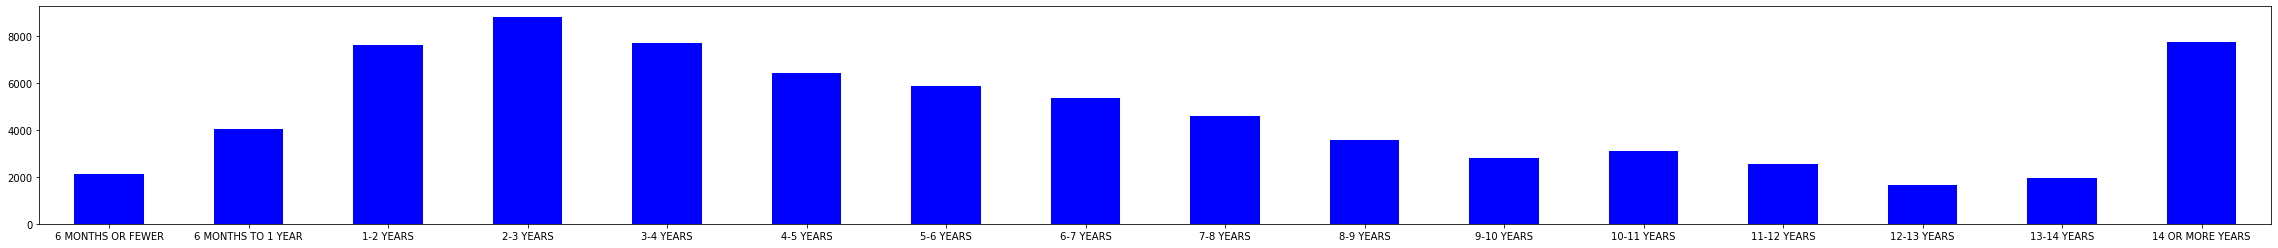

In [152]:
ax = BAH.value_counts().plot.bar(rot=0, color="b", figsize=(40,4))
ax.set_xticklabels(LABELS)

In [ ]:
out = pd.cut(s, bins=[0, 0.35, 0.7, 1], include_lowest=True)
ax = out.value_counts(sort=False).plot.bar(rot=0, color="b", figsize=(6,4))
ax.set_xticklabels([c[1:-1].replace(","," to") for c in out.cat.categories])
plt.show()

In [153]:
BAH.value_counts()

(0.0, 183.0]        2132
(183.0, 365.5]      4022
(365.5, 731.0]      7619
(731.0, 1096.5]     8823
(1096.5, 1462.0]    7716
(1462.0, 1827.5]    6444
(1827.5, 2193.0]    5865
(2193.0, 2558.5]    5342
(2558.5, 2924.0]    4587
(2924.0, 3289.5]    3560
(3289.5, 3655.0]    2821
(3655.0, 4020.5]    3093
(4020.5, 4386.0]    2527
(4386.0, 4751.5]    1661
(4751.5, 5117.0]    1947
(5117.0, 8000.0]    7754
dtype: int64